In [1]:
#!pip install dgl
#!DGLBACKEND=pytorch
#!export $DGLBACKEND
#import os
#os.environ["DGLBACKEND"] = "pytorch"
#print(os.environ["DGLBACKEND"])
import dgl
import numpy as np
#import tensorflow as tf
import torch as th

#!pip install forgi
import forgi
import forgi.graph.bulge_graph as fgb
import forgi.threedee as ft
import forgi.threedee.model.coarse_grain as ftmc


import matplotlib.pyplot as plt
import networkx as nx

Using backend: pytorch
[13:33:55] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: libtorch_cuda_cpp.so: cannot open shared object file: No such file or directory


In [2]:
print(th.__version__)
print(th.cuda.is_available())

1.10.0
True



Ideas: 
*   load coarse grain representation with forgi,
*   use forgi to form a graph with nodes labeled as s/i/o/.. and twist, length, angle,...
*   use that graph to feed into model
*   use dgl.save_graph() to store a graph, so the structure can be used for several steps?
*   use forgi.threedee.model.coarse_grain.CoarseGrainRNA.rotate() to rotate cg RNAs and see if the classification changes

TODO:
*  automate linking of labels to cg structures!
*  future --> find where ernwin writes/stores output of structure for each n steps
*  finetune the model
*  make larger batch of training data for testing
*  include logger (maybe wandb?)



In [94]:
#Graph Building

#load coarse grain file
def load_cg_file(file): 
    cg = ftmc.CoarseGrainRNA.from_bg_file(file) 
    c_dict = dict(cg.coords)
    t_dict = dict(cg.twists)
    coord_dict = {}
    twist_dict = {}
    for e in c_dict:
        a = th.from_numpy(c_dict[e][0])
        b = th.from_numpy(c_dict[e][1])
        coord_dict[e] = a, b
        if e in t_dict:
            c = th.from_numpy(t_dict[e][0])
            d = th.from_numpy(t_dict[e][1])
            twist_dict[e] = c, d
        
    # Get elements and neighbours:
    connections = {}
    for elem in cg.sorted_element_iterator():
        neighbours = cg.connections(elem)
        if elem not in connections:
            connections[elem] = cg.connections(elem)
    return coord_dict, twist_dict, connections

def build_dgl_graph(coord_dict, twist_dict, connections):
    #dictionary to convert type
    type_transl = {
        "h": [1, 0, 0, 0, 0, 0],
        "i": [0, 1, 0, 0, 0, 0],
        "m": [0, 0, 1, 0, 0, 0],
        "s": [0, 0, 0, 1, 0, 0],
        "f": [0, 0, 0, 0, 1, 0],
        "t": [0, 0, 0, 0, 0, 1]
    } 

    #encode nodes numerically for dgl graph
    num_graph = {}
    elem_count = {}
    for num, n in enumerate(sorted(connections)):
        num_graph[n] = num
        if n[0] not in elem_count:
            elem_count[n[0]] = 1
        else:
            elem_count[n[0]] += 1

    #build graph and edges
    u = []
    v = []
    for node in connections:
        for c in connections[node]:
            u.append(num_graph[node])
            v.append(num_graph[c])

    graph = dgl.graph((th.tensor(u), th.tensor(v)))

    #initialise node attributes
    graph.ndata["type"] = th.zeros(graph.num_nodes(), 6, dtype=th.float32)
    graph.ndata["coord"] = th.zeros(graph.num_nodes(), 6, dtype=th.float32) #seperate coords into 2 sets of 3, so that the information of start and end is added?
    graph.ndata["twist"] = th.zeros(graph.num_nodes(), 6, dtype=th.float32)

    for elem in connections:
        graph.ndata["type"][num_graph[elem]] = th.tensor(type_transl[elem[0]], dtype=th.float32) 
        graph.ndata["coord"][num_graph[elem]] = th.tensor(np.concatenate(coord_dict[elem]), dtype=th.float32)
        if elem in twist_dict:
            graph.ndata["twist"][num_graph[elem]] = th.tensor(np.concatenate(twist_dict[elem]), dtype=th.float32)
  
    return graph



In [95]:
#Graph Dataset Class
#TODO: adapt, so it can stand alone
#      link labels to files!!!!

import os

from dgl.data import DGLDataset
class CGDataset(DGLDataset):
    def __init__(self, directory):
        self.file_path = directory
        super(CGDataset, self).__init__(name="cgRNA")#, raw_dir=directory)
        
        
    def process(self):
        self.graphs = []
        self.labels = [12.722, 4.891, 22.918, 12.147] #get this right and link to files
        
        files = []
        filenames = next(os.walk(self.file_path), (None, None, []))[2]

        for file in filenames:
            if file.endswith(".cg"):
                files.append(file)

        for struc in files:
            coord_dict, twist_dict, connections = load_cg_file(os.path.join(training_dir, struc))
            graph = build_dgl_graph(coord_dict, twist_dict, connections)
            self.graphs.append(build_dgl_graph(coord_dict, twist_dict, connections))

        self.labels = th.tensor(self.labels)
  
    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)


In [96]:
#Save/Load Training Data
#TODO: make a function to save the data
#import os

#training_dir = "./training_set"

#g_list = []
#glabels ={"rmsd": th.tensor([12.722, 4.891, 22.918, 12.147])} #done with: compare_RNA.py data/6CU1.pdb /home/mescalin/mgeyer/3d_classifier/6cu1.cg

#files = []
#filenames = next(os.walk(training_dir), (None, None, []))[2]

#for file in filenames:
#    if file.endswith(".cg"):
#        files.append(file)

#for struc in files:
#    coord_dict, twist_dict, connections = load_cg_file(os.path.join(training_dir, struc))
#    graph = build_dgl_graph(coord_dict, twist_dict, connections)
#    g_list.append(graph)

# save_graphs, label is rmsd
dgl.save_graphs(training_dir + "/training_cg_graphs.dgl", g_list, labels=glabels)
gs, ls = dgl.load_graphs(training_dir + "/training_cg_graphs.dgl")
print(gs)
print(ls)

[Graph(num_nodes=14, num_edges=26,
      ndata_schemes={'twist': Scheme(shape=(6,), dtype=torch.float32), 'coord': Scheme(shape=(6,), dtype=torch.float32), 'type': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=15, num_edges=30,
      ndata_schemes={'twist': Scheme(shape=(6,), dtype=torch.float32), 'coord': Scheme(shape=(6,), dtype=torch.float32), 'type': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=4, num_edges=6,
      ndata_schemes={'twist': Scheme(shape=(6,), dtype=torch.float32), 'coord': Scheme(shape=(6,), dtype=torch.float32), 'type': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={})]
{'rmsd': tensor([12.7220,  4.8910, 22.9180, 12.1470])}


In [97]:
#Dataloading
import dgl.dataloading as dtl

b_size = 2

training_dir = "./training_set"

training_dataset = CGDataset(training_dir)
#dataset.process(training_dir)
#graph, label = dataset[0]
#print(graph, label)

#add randomisation as in Defining Data Loader from https://docs.dgl.ai/tutorials/blitz/5_graph_classification.html
train_dataloader = dtl.pytorch.GraphDataLoader(training_dataset, batch_size=b_size, shuffle=True) 


In [98]:
#Model
from dgl.nn import GraphConv
import torch.nn.functional as F

# feed the 3 different node attributes one after the other though the first layer? like in https://discuss.dgl.ai/t/getting-started-with-multiple-node-features-in-homogenous-graph/919/2
# condense the 3 node attributes down to 1? see point above


#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self, in_dim, hidden_dim, num_features):
        super(CG_Classifier, self).__init__()
        
        self.conv1 = GraphConv(in_dim, hidden_dim, activation=F.relu)
        self.conv2 = GraphConv(hidden_dim, hidden_dim, activation=F.relu)
        
        self.max_pool = dgl.nn.MaxPooling()
        
        self.dense1 = th.nn.Linear(hidden_dim*num_features, 256)
        self.dense2 = th.nn.Linear(256, 256)
        self.dense3 = th.nn.Linear(256, 256)
        self.classify = th.nn.Linear(256, 1)

    def forward(self, g):#, n_types, n_coord, n_twist):
        nt = g.ndata["type"]
        nc = g.ndata["coord"]
        nw = g.ndata["twist"]
        
        nt = self.conv1(g, nt)
        nt = self.max_pool(g, nt)
        nt = self.conv2(g, nt)
        nt = self.max_pool(g, nt)
        
        nc = self.conv1(g, nc)
        nc = self.max_pool(g, nc)
        nc = self.conv2(g, nc)
        nc = self.max_pool(g, nc)
        
        nw = self.conv1(g, nw)
        nw = self.max_pool(g, nw)
        nw = self.conv2(g, nw)
        nw = self.max_pool(g, nw)

        #use pooling to have still a graph representation, after 2 layers of seperate conv
        #--> let conv run over the pooled graph

        tcw = th.cat((nt, nc, nw), 1)

        #is the mean the right approach?
        tcw_mean = tcw.mean(dim=0)
        tcw_mean = self.dense1(tcw_mean)
        tcw_mean = self.dense2(tcw_mean)
        tcw_mean = self.dense3(tcw_mean)
        
        return self.classify(tcw_mean)
    

/tmp/ipykernel_28490/1663031686.py:32: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  batch_loss += F.smooth_l1_loss(prediction, batch_labels[i]) #F.cross_entropy(prediction, label) #th.abs((prediction - label))
/tmp/ipykernel_28490/1663031686.py:47: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.smooth_l1_loss(val_pred, val_label)


Epoch 0: Training loss 12.7493, Validation loss 3057.8567
Epoch 5: Training loss 10522.7754, Validation loss 5095.5474
Epoch 10: Training loss 31.3140, Validation loss 938.7620
Epoch 15: Training loss 143.6006, Validation loss 19.8089
Epoch 20: Training loss 41.9005, Validation loss 75.7576
Epoch 25: Training loss 54.7204, Validation loss 70.3297
Epoch 30: Training loss 40.8427, Validation loss 87.8752
Epoch 35: Training loss 64.3743, Validation loss 27.8713
Epoch 40: Training loss 5.1311, Validation loss 9.8563
Epoch 45: Training loss 7.6676, Validation loss 9.4366
Epoch 50: Training loss 5.0654, Validation loss 0.1854
Epoch 55: Training loss 11.3703, Validation loss 7.5836
Epoch 60: Training loss 31.7135, Validation loss 33.0669
Epoch 65: Training loss 31.0185, Validation loss 8.0553
Epoch 70: Training loss 22.3534, Validation loss 29.1071
Epoch 75: Training loss 17.1818, Validation loss 2.0576
Epoch 80: Training loss 9.3804, Validation loss 11.4534
Epoch 85: Training loss 5.7738, Va

<function matplotlib.pyplot.draw()>

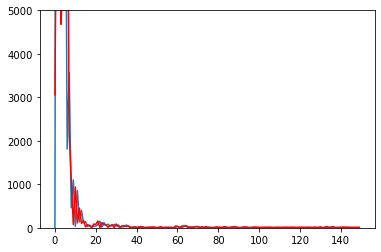

In [99]:
#Training
#TODO: figure out the loss function
#       build a deeper neural network and how to pool
#       tinker with hyperparameters

model = CG_Classifier(
    in_dim=6, #num of pos in type, twist, coord
    hidden_dim=12,
    num_features=3 #len(graph.ndata)
)

opt = th.optim.Adam(model.parameters(), lr=0.1)
model.train()

epochs = 150

#temp val setup --> use dataloader for larger set
val_losses = []
val_label = th.tensor(0.934)
vcoord_dict, vtwist_dict, vconnections = load_cg_file("1ehz.cg")
val_graph = build_dgl_graph(vcoord_dict, vtwist_dict, vconnections)

#training setup
epoch_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    
    for iter, (batch, batch_labels) in enumerate(train_dataloader):
        batch_loss = th.tensor(0.0, dtype=th.float32)
        for i, batched_g in enumerate(dgl.unbatch(batch)): #use another method? see https://docs.dgl.ai/guide/training-graph.html#computation-on-a-batched-graph
            prediction = model(batched_g)
            batch_loss += F.smooth_l1_loss(prediction, batch_labels[i]) #F.cross_entropy(prediction, label) #th.abs((prediction - label))
        
        #using the mean of all losses of a single batch for backpropagation
        loss = batch_loss/b_size

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)

    #val setup
    val_pred = model(val_graph)
    val_loss = F.smooth_l1_loss(val_pred, val_label)
    val_losses.append(val_loss.detach().item())
    
    if epoch % 5 == 0 or epoch == epochs-1:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}".format(epoch, epoch_loss, val_loss))

#plot the training run
plt.plot(epoch_losses)
plt.plot(val_losses, 'r')
plt.ylim(ymax=5000, ymin=0)
plt.draw

In [86]:
#Test with 1ehz.cg

test_label = th.tensor(0.934)
tcoord_dict, ttwist_dict, tconnections = load_cg_file("1ehz.cg")
test_graph = build_dgl_graph(tcoord_dict, ttwist_dict, tconnections)


#tn_types = test_graph.ndata["type"]
#tn_coord = test_graph.ndata["coord"]
#tn_twist = test_graph.ndata["twist"]

pred = model(test_graph)#, tn_types, tn_coord, tn_twist)
loss = F.smooth_l1_loss(pred, test_label)
print("Predicted RMSD of 1EHZ (3rd best cg with ernwin): {:.4f}; true RMSD: {:.4f}; loss: {:.4f}".format(float(pred), float(test_label), float(loss)))

Predicted RMSD of 1EHZ (3rd best cg with ernwin): 11.8644; true RMSD: 0.9340; loss: 10.4304


/tmp/ipykernel_28490/716465133.py:13: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(pred, test_label)
